# Genetic Algorithm 
## Investigación de Operaciones, ITAM (2023). 

@author: Diego Velázquez Trejo

@author: Viviana de los Ríos


### Required libraries

In [2]:
# Library for matrix operations
import numpy as np 
# Library for time operations
import time 
# Library for random operations
import random 
# Library for plotting
from matplotlib import pyplot as plt 

# Auxiliar functions 

In [3]:
# Function that prints the population 
def print_pop(population): 
  print("Population: ")
  for i in range(len(population)): 
    if(i % 10 == 0): 
      print("\n")
    print(population[i].toString(), end = ", ")


# Genetic Algorithm

In [4]:
'''
Genetic algorithm
'''
class GeneticAlgo: 

    # Constructor of the class  
    def __init__(self, initialPop, ObjectiveFunction, cruza, mutacion, cross_rate = 0.3, mutation_rate = 0.3, method = "cross.over.probabilistic",  mutation_method = "uniform.mutation", gens = 100): 
        # Population
        self.population = initialPop
        # Cross rate 
        self.cross_rate = cross_rate
        # Mutation rate 
        self.mutation_rate = mutation_rate
        # Cross Method 
        self.method = method 
        # Number of cicles to be done 
        self.gens = gens
        # Array that contains the fitness measures 
        self.fitness_measures = np.zeros(len(self.population))
        # Mutation method 
        self.mutation_method = mutation_method
        # Objective function 
        self.ObjectiveFunction = ObjectiveFunction
        # Cross methods
        self.CrossMethods = cruza
        # Mutation methods
        self.MutationMethods = mutacion
    
    # Method for selecting the cross over technique
    def select_cross_over_method(self, element1, element2):
        return self.CrossMethods[self.method](element1, element2, self.cross_rate)

    # Mutation methods 
    def select_mutation_method(self,element1):
        return self.MutationMethods[self.mutation_method](element1, self.mutation_rate)

    # Fitness function (returns probabilities of each individual)
    def fitness(self):
        for i in range(0, len(self.population)):
            self.fitness_measures[i] = self.ObjectiveFunction(self.population[i])
        # Calculate probabilities of each individual. We will standarize this vector using min max value 
        self.fitness_measures = (self.fitness_measures-np.min(self.fitness_measures))/((np.max(self.fitness_measures)-np.min(self.fitness_measures)) + 0.01)

    # Bernoui's method (selection)
    def bernoulli(self):
        elements = []; i = 0;  ITERMAX = 10 ; iters = 0
        while(i != 2 and iters < ITERMAX):
            # Select the index of a random element in the population
            index_element = int(random.random() * len(self.population))
            # Select a random number between 0 and 1
            if( random.random() < self.fitness_measures[index_element]):
                elements.append(self.population[index_element]); i += 1 
            iters += 1
        # Cĺausula de escape para la selección 
        while(len(elements) < 2): 
            elements.append(self.population[int(random.random() * len(self.population))])
        return elements[0], elements[1]

    # Algorithm's main function
    def run(self):
        print("Cross rate: ", self.cross_rate, "Mutation rate: ", self.mutation_rate, "Method: ", self.method, "Mutation method: ", self.mutation_method, "Gens: ", self.gens) 
        # Array with the mean for each gen 
        fit = []
        # Iterate for each generation
        t0 = time.time()
        for i in range(self.gens): 
            new_pop = []
            # Calculate fitness
            self.fitness()
            # Iterate for each element in the population to be crossed
            for j in range(int(len(self.population)/2)):
                # Get two random elements from the population
                element1, element2 = self.bernoulli()
                # Cross the two elements
                element1, element2 = self.select_cross_over_method(element1, element2)
                # Mutate the new element
                self.select_mutation_method(element1)
                self.select_mutation_method(element2)

                # Add the new element to the population
                new_pop.append(element1)
                new_pop.append(element2)

            # Get the index associated with the best individual
            best_individual = np.argmax(self.fitness_measures)
            # Get the best individual
            best_individual = self.population[best_individual]
            # Add the best individual to the new population
            new_pop[-1] = best_individual
            # Get the best individual 
            self.population = new_pop
            # Report results
            if(i % 20 == 0): 
                print("------------------------------------------------------")
                print("| Generation: ", i, " Average pop: ", np.mean(self.fitness_measures),"|")
                print("------------------------------------------------------")
            fit.append(np.mean(self.fitness_measures))
        
        best_element = self.population[0]
        print(f"Total time {time.time() - t0} secs")
        return self.population, best_element, fit


# Reading the data for the Genetic Algorithm 

In [5]:

'''
Programa Main para la optimización del problema de la mochila
@author Diego Velázquez Trejo

'''
from leyendo_datos_mochila import CONJUNTO_OBJETOS
from leyendo_datos_mochila import CAPACIDAD
from leyendo_datos_mochila import OBJETOS_TOTALES # Va a ser importante tener esta variable en mente cuando intentemos crear tantas mochilas con objetos y que sean más objetos de los que predisponemos 
from Mochila import Mochila
import random

conjunto_identificadores = set() # Contiene los identificadores de los objetos que se pueden insertar en las mochilas (será una variable auxiliar)

for i in range(1, len(CONJUNTO_OBJETOS)+1):
    conjunto_identificadores.add(str(i))


# Necesito una función para generar una mochila inicial VÁLIDA
def genera_mochila_valida(informacion = CONJUNTO_OBJETOS, capacidad = CAPACIDAD):
    # Copia del conjunto
    M0 = Mochila(set(), capacidad)
    el = conjunto_identificadores.pop()
    while(M0.agrega_elemento(el) and len(conjunto_identificadores) > 0):
        el = conjunto_identificadores.pop()
    # Agregamos el último elemento que se sacó del ciclo while y que ya no entró a la mochila 
    conjunto_identificadores.add(el)
    return M0


# Vemos los resultados de una mochila inicial y del conjunto de identificadores
print(f"\nTamaño del conjunto de potenciales objetos: {len(conjunto_identificadores)}\n\n")
# Vamos a generar una población de 100 mochilas 
initialPop = []

total_elementos_agregados_a_mochila = 0 

size_pop = 50

for i in range(size_pop):
    M = genera_mochila_valida()
    initialPop.append(M)
    total_elementos_agregados_a_mochila += M.longitud()

# Vamos a imprimir cada mochila 

print_pop(initialPop)
print(f"\n\n\nCantidad de objetos que están disponibles para configurar más mochilas: {len(conjunto_identificadores)}")
print(f"Cantidad de objetos dentro de las mochilas: {total_elementos_agregados_a_mochila}\n")



Tamaño del conjunto de potenciales objetos: 10000


Population: 


Capacidad: 1000000, #Elemetos: 7, Peso: 919503, Valor:892618 : {'4494', '1029', '7017', '1466', '1472', '1954', '6041'}, Capacidad: 1000000, #Elemetos: 10, Peso: 893972, Valor:907468 : {'9383', '5337', '86', '7614', '1803', '9298', '8736', '4032', '4071', '9242'}, Capacidad: 1000000, #Elemetos: 9, Peso: 848005, Valor:813995 : {'7586', '1557', '5339', '2192', '2090', '34', '7608', '7449', '8950'}, Capacidad: 1000000, #Elemetos: 10, Peso: 831291, Valor:807154 : {'6391', '7370', '4735', '9251', '114', '3100', '6449', '6640', '2576', '3482'}, Capacidad: 1000000, #Elemetos: 9, Peso: 983868, Valor:954575 : {'7978', '1731', '5643', '4355', '3519', '2428', '5018', '3592', '4011'}, Capacidad: 1000000, #Elemetos: 12, Peso: 876083, Valor:853314 : {'6155', '788', '7873', '7961', '8525', '2130', '5245', '7963', '1496', '8964', '9902', '9457'}, Capacidad: 1000000, #Elemetos: 9, Peso: 989991, Valor:955008 : {'266', '4644', '8296', '2

# Genetic functions

In [6]:
# Función para agregar un elemento a la mochila 
def agrega_elemento_mochila(mochila, iters): 
    # En caso de haber llegado al máximo de llamadas recursivas intentando agregar un elemento, regresamos False
    if(iters > 3): 
        return False
    # Extraemos un elemento aleatorio del conjunto de identificadores
    elemento = random.choices(list(conjunto_identificadores),k=1)[0]
    if(mochila.agrega_elemento(elemento)):
        # Eliminamos elemento del conjunto de identificadores
        conjunto_identificadores.remove(elemento)
        return True 
    else: 
        return agrega_elemento_mochila(mochila, iters + 1)

# Recordar que el objeto mochila posee los siguientes métodos: obtiene_elemento y agrega_elemento
# En donde obtiene_elemento extraer un elemento aleatorio de la mochila (eliminándolo de la misma). 
# También tiene: longitud (regresa la cantidad de elementos que posee)
# Tambiém tiene: lista_elementos (para obtener los identificadores de los objetos que están dentro de la mochila)

def CrossOver(mochila1, mochila2, crossRate):
    pass 

def CrossOverToss(mochila1, mochila2, crossRate):
    pass

# Vamos a utilizar únicamente este método de cruce ya que aquí no importa la posición de los objetos que conforman a la mochila 
def CrossOverProbabilistic(mochila1, mochila2, crossRate):
    # Caso en donde no se lleva a cabo la mutación 
    if(random.random() > crossRate):
        return mochila1, mochila2
        
    # Vamos a obtener los elementos de la mochila1 y los elementos de la mochila2
    elementos_mochila1 = mochila1.lista_elementos()
    elementos_mochila2 = mochila2.lista_elementos()

    # Vamos a concatenar la lista de elementos_mochila1 y elementos_mochila2
    elementos = elementos_mochila1 + elementos_mochila2

    # Vamos a generar dos nuevas mochilas
    nueva_mochila1 = Mochila(set(), CAPACIDAD)
    nueva_mochila2 = Mochila(set(), CAPACIDAD)

    for elemento in elementos: 
        if(random.random() < 0.5): 
            res = nueva_mochila1.agrega_elemento(elemento)
            if(res == False and nueva_mochila2.agrega_elemento(elemento) == False): 
                    conjunto_identificadores.add(elemento)
        else: 
            res = nueva_mochila2.agrega_elemento(elemento)
            # Intentamos ahora colocarlo en la primera mochila 
            if(res == False and nueva_mochila1.agrega_elemento(elemento) == False):
                conjunto_identificadores.add(elemento)
    return nueva_mochila1, nueva_mochila2

# Función que escogerá un índice aleatorio del conjunto de identificadores y lo agregará a la mochila, quitando uno 
def MutateElement(mochila, mutationRate):
    if(random.random() < mutationRate):
        # Removemos un elemento aleatorio de la mochila 
        elemento = mochila.obtiene_elemento()
        # Tenemos que agregar un nuevo elemento del conjunto_identificadores (siempre y cuando siga respetando la capacidad de la mochila)
        res = agrega_elemento_mochila(mochila, 0)
        # En caso que sí se haya podido agregar un elemento, entonces agregamos el elemento que se sacó de la mochila al conjunto de identificadores
        if(res):
            conjunto_identificadores.add(elemento)
        else: 
            # En caso que no se haya podido agregar un nuevo elemento a la mochila, entonces agregamos el elemento que se sacó de la mochila a la mochila
            mochila.agrega_elemento(elemento)

    return mochila        

# Función que se encargará de iterar sobre los identificadores de la mochila y cambiar uno, dependiendo un u ~ U(0,1)
def MutateElementInversion(mochila, mutationRate):
    pass 

# Vamos a definir los métodos por fuera y pasarlos como parámetros
MetodosCruza = {
    "cross.Over": CrossOver, 
    "cross.Over.Toss": CrossOverToss,
    "cross.over.probabilistic": CrossOverProbabilistic
}

MetodosMutacion = {
    "uniform.mutation": MutateElement,
    "inversion.mutation": MutateElementInversion
}

In [13]:
# Vamos a fijar una semilla para poder reproducir los resultados
random.seed(87)

# Función objetivo: 
# Función objetivo (le pasamos un objeto Mochila)
def F(M):
    # Podemos usar el hecho de que el peso no haya aumentado más que el peso que tenía mas el promedio de pesos
    return M.valor

# Create the genetic algorithm
genetic = GeneticAlgo(initialPop, ObjectiveFunction = F, cruza= MetodosCruza, mutacion = MetodosMutacion, 
                    cross_rate = 0.45, mutation_rate = 0.05, method = "cross.over.probabilistic", 
                    mutation_method = "uniform.mutation", gens = 150)

res, best, fit = genetic.run()

Cross rate:  0.45 Mutation rate:  0.05 Method:  cross.over.probabilistic Mutation method:  uniform.mutation Gens:  150
------------------------------------------------------
| Generation:  0  Average pop:  0.5775295696682005 |
------------------------------------------------------
------------------------------------------------------
| Generation:  20  Average pop:  0.6719604470229218 |
------------------------------------------------------
------------------------------------------------------
| Generation:  40  Average pop:  0.9360931293758383 |
------------------------------------------------------
------------------------------------------------------
| Generation:  60  Average pop:  0.7866979673996772 |
------------------------------------------------------
------------------------------------------------------
| Generation:  80  Average pop:  0.8988884088679779 |
------------------------------------------------------
------------------------------------------------------
| Gener

# Now, we get the best element and the final population

In [14]:
print(f"Final population: ")
print_pop(res)
print("\n\n\n---------------------------------------------\n\n")
print(f"The element that maximizes the objetive function is: \t\t{best.toString()}")

Final population: 
Population: 


Capacidad: 1000000, #Elemetos: 10, Peso: 999210, Valor:1051789 : {'8782', '2506', '8923', '3392', '4052', '7983', '7382', '7489', '3534', '7966'}, Capacidad: 1000000, #Elemetos: 10, Peso: 999210, Valor:1051789 : {'2506', '8782', '8923', '3392', '4052', '7983', '7382', '7489', '3534', '7966'}, Capacidad: 1000000, #Elemetos: 10, Peso: 999210, Valor:1051789 : {'2506', '8782', '8923', '3392', '4052', '7983', '7382', '7489', '3534', '7966'}, Capacidad: 1000000, #Elemetos: 10, Peso: 999210, Valor:1051789 : {'2506', '8782', '8923', '3392', '4052', '7983', '7382', '7489', '3534', '7966'}, Capacidad: 1000000, #Elemetos: 10, Peso: 999210, Valor:1051789 : {'8782', '2506', '8923', '3392', '4052', '7983', '7382', '7489', '3534', '7966'}, Capacidad: 1000000, #Elemetos: 10, Peso: 999210, Valor:1051789 : {'8782', '2506', '8923', '3392', '4052', '7983', '7382', '7489', '3534', '7966'}, Capacidad: 1000000, #Elemetos: 10, Peso: 999210, Valor:1051789 : {'8782', '2506', '8

Plotting results

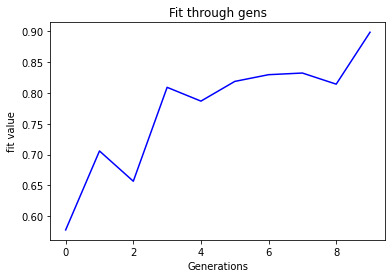

In [17]:
# Plotting the results
plt.xlabel('Generations')
plt.ylabel('fit value')
# Vamos a graficar cada 15 valores de fit 
plt.plot(fit[::15], c = 'blue')
#plt.plot(fit, c = 'red')
plt.title('Fit through gens')
plt.show()

# Comparación de diferentes semillas 

In [10]:
# List of seeds
semillas = [67, 87, 89, 12, 23, 34, 56, 78, 90, 11, 22, 33, 44, 55, 66, 77, 88, 99, 100]

resultados = {}

for j in range(0, len(semillas)): 
    # Set specific seed 
    random.seed(semillas[j])

    # Create the population
    conjunto_identificadores = set()
    for i in range(1, len(CONJUNTO_OBJETOS)+1):
        conjunto_identificadores.add(str(i))
    initialPop = []
    size_pop = 50
    for i in range(size_pop):
        M = genera_mochila_valida()
        initialPop.append(M)

    # Create the genetic algorithm
    genetic = GeneticAlgo(initialPop, ObjectiveFunction = F, cruza= MetodosCruza, mutacion = MetodosMutacion, 
                        cross_rate = 0.45, mutation_rate = 0.05, method = "cross.over.probabilistic", 
                        mutation_method = "uniform.mutation", gens = 150)

    res, best, fit = genetic.run()

    resultados[semillas[j]] = best.valor 



Cross rate:  0.45 Mutation rate:  0.05 Method:  cross.over.probabilistic Mutation method:  uniform.mutation Gens:  150
------------------------------------------------------
| Generation:  0  Average pop:  0.5282199439604348 |
------------------------------------------------------
------------------------------------------------------
| Generation:  20  Average pop:  0.7362322564551573 |
------------------------------------------------------
------------------------------------------------------
| Generation:  40  Average pop:  0.7904648614787413 |
------------------------------------------------------
------------------------------------------------------
| Generation:  60  Average pop:  0.7507571415912804 |
------------------------------------------------------
------------------------------------------------------
| Generation:  80  Average pop:  0.8316603847085655 |
------------------------------------------------------
------------------------------------------------------
| Gener

In [11]:
# Vamos a ordenar el diccionario por valor 
resultados = dict(sorted(resultados.items(), key=lambda item: item[1], reverse=True))
print(resultados)

{11: 1078872, 56: 1077094, 12: 1075415, 87: 1074986, 66: 1071937, 23: 1070155, 55: 1068617, 99: 1066531, 44: 1064659, 78: 1064218, 88: 1064176, 77: 1062760, 100: 1061370, 22: 1060145, 33: 1051400, 90: 1042295, 89: 1010027, 67: 1007245, 34: 961383}
